In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# sklearn :: models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set_style('whitegrid')

# Problem definition

Apply regression models to predict the house pricing

# Load the data

In [2]:
#input
df = pd.read_csv('data/default of credit card clients.csv')
print(df.columns)
df.head()

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Feature Engineering 

In [3]:
# Cleaning according to the data dictionary
# https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
print(len(df))
# X2: Gender (1 = male; 2 = female). 
df = df[df['SEX'].isin([1,2])]
# X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
df = df[df['EDUCATION'].isin([1,2,3,4])]
#X4: Marital status (1 = married; 2 = single; 3 = others). 
df = df[df['MARRIAGE'].isin([1,2,3])]
print(len(df))

30000
29601


In [4]:
# SEX, EDUCATION, MARRIAGE  to numerical columns
df_sex = pd.get_dummies(df['SEX'])
df_sex.columns = ['male', 'female']
df_education = pd.get_dummies(df['EDUCATION'])
df_education.columns = ['graduate school','university','high school','education_others']
df_marriage = pd.get_dummies(df['MARRIAGE'])
df_marriage.columns = ['married','single','marriage_others']
df = pd.concat([df_sex, df_education, df_marriage, df], axis=1)
df.head()

,male,female,graduate school,university,high school,education_others,married,single,marriage_others,ID,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0,1,0,1,0,0,1,0,0,1,...,0,0,0,0,689,0,0,0,0,1
1,0,1,0,1,0,0,0,1,0,2,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,0,1,0,1,0,0,0,1,0,3,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0,1,0,1,0,0,1,0,0,4,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,1,0,0,1,0,0,1,0,0,5,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
# Remove not necessary columns
del df['ID']
del df['SEX']
del df['EDUCATION']
del df['MARRIAGE']

In [6]:
# feature engineering
X_columns = df.columns[:-1]
y_column = df.columns[-1]

# Model Training

In [7]:
# split the data

threshold = 0.8
X = df[X_columns]
y = df[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (23680, 29)
y_train (23680,)
X_test (5921, 29)
y_test (5921,)


# Model Training / Evaluation - Using Split

In [8]:
models = [
    ('Naive Bayes', GaussianNB()),
    ('RandomForestClassifier10', RandomForestClassifier(n_estimators=10)),
    ('RandomForestClassifier100', RandomForestClassifier(n_estimators=100)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier())
]
results = []
for m in models:
    print('MODEL', m[0])
    model = m[1]
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print('Precision', precision)
    print('Recall', recall)
    results.append([m[0], precision, recall])
    
    # if there is a feature importance, print top 5
    importance = []
    if hasattr(model, 'feature_importances_'):
        print('Feature Importance')
        importance = []
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.feature_importances_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False).head())
    elif hasattr(model, 'coef_'):
        print('Feature Importance')
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.coef_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False).head())
        
    print('')

# sort the results and print as a table
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'precision', 'recall']
df_results = df_results.sort_values(by='precision', ascending=False)
df_results

MODEL Naive Bayes
[[1157 3403]
 [ 157 1204]]
Precision 0.261341436944
Recall 0.884643644379

MODEL RandomForestClassifier10
[[4280  280]
 [ 892  469]]
Precision 0.626168224299
Recall 0.344599559148
Feature Importance
            0         1
11      PAY_0  0.084449
10        AGE  0.064387
9   LIMIT_BAL  0.061964
17  BILL_AMT1  0.058520
13      PAY_3  0.053130

MODEL RandomForestClassifier100
[[4284  276]
 [ 846  515]]
Precision 0.651074589128
Recall 0.378398236591
Feature Importance
            0         1
11      PAY_0  0.093229
10        AGE  0.066085
17  BILL_AMT1  0.059737
9   LIMIT_BAL  0.057919
18  BILL_AMT2  0.052554

MODEL KNeighborsClassifier
[[4170  390]
 [1091  270]]
Precision 0.409090909091
Recall 0.198383541514

MODEL DecisionTreeClassifier
[[3671  889]
 [ 771  590]]
Precision 0.398918187965
Recall 0.4335047759
Feature Importance
            0         1
11      PAY_0  0.161950
10        AGE  0.073556
17  BILL_AMT1  0.068561
9   LIMIT_BAL  0.060692
25   PAY_AMT3  0.055276



,model,precision,recall
2,RandomForestClassifier100,0.651075,0.378398
1,RandomForestClassifier10,0.626168,0.344600
3,KNeighborsClassifier,0.409091,0.198384
4,DecisionTreeClassifier,0.398918,0.433505
0,Naive Bayes,0.261341,0.884644


# Model Training / Evaluation - Cross Validation

In [9]:
models = [
    ('Naive Bayes', GaussianNB()),
    ('RandomForestClassifier10', RandomForestClassifier(n_estimators=10)),
    ('RandomForestClassifier100', RandomForestClassifier(n_estimators=100)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier())
]

k = 10
results = {}
for m in models:
    print('MODEL', m[0])
    results[m[0]] = {'precision':[], 'recall':[]}
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model = m[1]
        model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        results[m[0]]['precision'].append(precision)
        results[m[0]]['recall'].append(recall)

MODEL Naive Bayes
MODEL RandomForestClassifier10
MODEL RandomForestClassifier100
MODEL KNeighborsClassifier
MODEL DecisionTreeClassifier


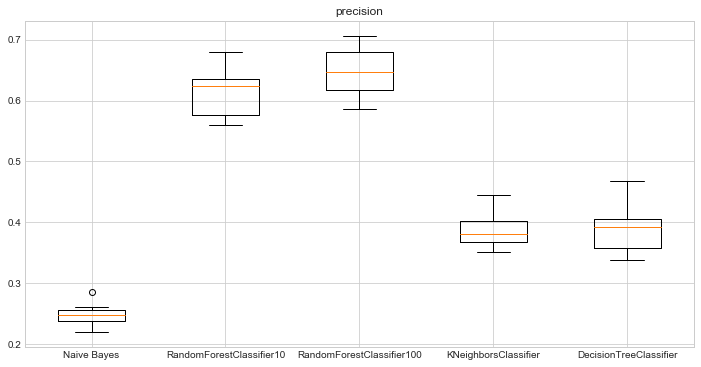

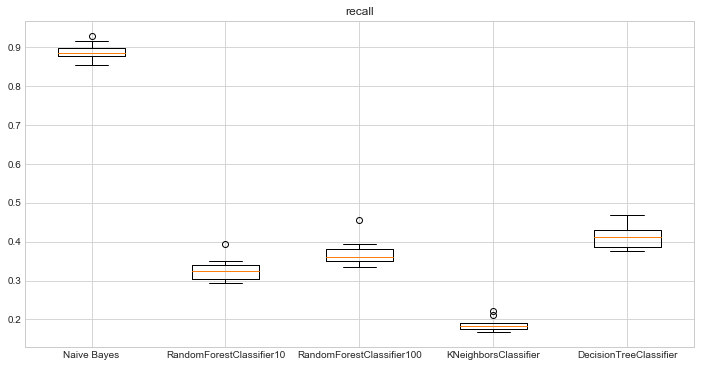

In [10]:
for metric in ['precision', 'recall']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
    plt.show()